## Core microbiome thresholds / Figure 2

All files on farm in `/home/ctbrown/scratch3/2025-workflow-core99/`

In [1]:
# base checkout of workflow directory is here:
BASE='/home/ctbrown/scratch3/2025-workflow-core99/'

# parquet files from 'sourmash gather' against 3,216 metagenomes
BASE_OUTPUTS=BASE+'/inputs.pangenome-gather'

# where to place figures
FIG_OUT=BASE+'/outputs.figures/'

In [2]:
import polars as pl
import glob
import matplotlib.pyplot as plt

In [3]:
filenames = glob.glob(BASE_OUTPUTS + '/*.parquet')

dflist = []
total_rows = 0
for n, csvfile in enumerate(filenames):
    if n % 1000 == 0 and n:
        print(f'...reading {n} of {len(filenames)} parquets')
    df = pl.read_parquet(csvfile)
    # don't pfaff about; support both gather and fast(multi)gather results
    df = df.with_columns([pl.col("name").alias("match_name")])
    df = df.select(["match_name", "f_match_orig", "query_name", "unique_intersect_bp", "scaled"])
    dflist.append(df)
    total_rows += len(df)

all_df = pl.concat(dflist, how='vertical')

...reading 1000 of 3216 parquets
...reading 2000 of 3216 parquets
...reading 3000 of 3216 parquets


In [4]:
assert all_df["query_name"].n_unique() == 3216
print(f"loaded {all_df['query_name'].n_unique()} gathers.")

loaded 3216 gathers.


In [5]:
all_df

match_name,f_match_orig,query_name,unique_intersect_bp,scaled
str,f64,str,i64,i64
"""GCA_934438315 s__Blautia_A sp0…",0.58837,"""SRR8960280""",10786000,1000
"""GCA_041324565 s__Gemmiger quci…",0.227761,"""SRR8960280""",10147000,1000
"""GCA_946011765 s__Prevotella sp…",0.290092,"""SRR8960280""",7941000,1000
"""GCA_963592815 s__Faecalibacter…",0.288318,"""SRR8960280""",6278000,1000
"""GCA_022779425 s__Sodaliphilus …",0.157451,"""SRR8960280""",6173000,1000
…,…,…,…,…
"""GCA_017506735 s__Faecousia sp0…",0.003538,"""SRR11125318""",1000,1000
"""GCA_949297075 s__UBA8612 sp949…",0.005961,"""SRR11125318""",1000,1000
"""GCA_019420465 s__UBA11957 sp01…",0.018519,"""SRR11125318""",1000,1000


In [6]:
meta_df = pl.read_csv(BASE + '/inputs.metadata/SRA_meta.3216.csv')
meta_df = meta_df.select(['acc', 'mbases'])
meta_df

acc,mbases
str,i64
"""SRR8960471""",4274
"""ERR1135330""",6819
"""SRR8960499""",5236
"""SRR8960204""",16136
"""ERR1135371""",7026
…,…
"""SRR11183408""",1032
"""SRR8960862""",7212
"""SRR8960937""",5460


In [15]:
def filter_combined_df_by_threshold(combined_df, frac, threshold_bp):
    min_mbases = 1000
    sub_df = combined_df.filter(((pl.col("mbases") >= min_mbases) & 
                                (pl.col("unique_intersect_bp") >= threshold_bp)))

    total = sub_df["query_name"].n_unique()
    cutoff = int(frac * total + 1)

    group_df = sub_df.group_by('match_name') \
            .agg(pl.len()) \
            .filter(pl.col("len") >= cutoff)
    return (cutoff, total, group_df)

In [16]:
combo_df = all_df.join(meta_df, left_on='query_name', right_on='acc')

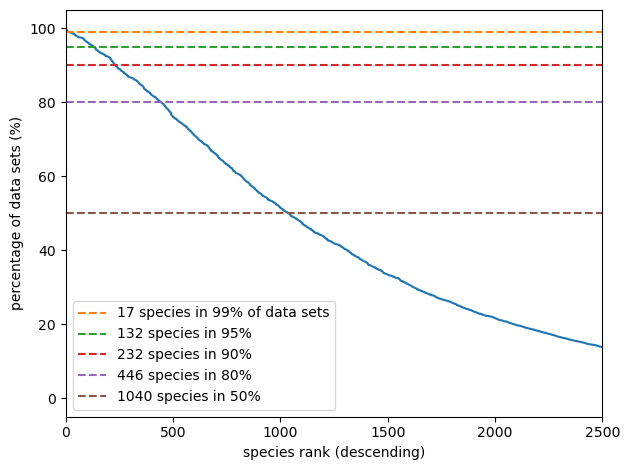

In [17]:
frac = 0
min_mbases = 1000
cutoff, total, group_df = filter_combined_df_by_threshold(combo_df, frac, 10_000)
#print(f"at {min_mbases/1000}gb, there are {len(group_df)} species present across at least {frac*100:.1f}% ({cutoff}) of the {total} datasets")

group_df = group_df.sort("len", descending=True).with_columns(
    (pl.col("len") / total).alias("frequency")
).with_row_index(name="rank")

len99 = len(group_df.filter(pl.col("frequency") >= 0.99))
len95 = len(group_df.filter(pl.col("frequency") >= 0.95))
len90 = len(group_df.filter(pl.col("frequency") >= 0.90))
len80 = len(group_df.filter(pl.col("frequency") >= 0.80))
len50 = len(group_df.filter(pl.col("frequency") >= 0.50))


plt.plot(group_df["rank"], group_df["frequency"]*100)
plt.plot([0, len(group_df)], [99, 99], '--', label=f'{len99} species in 99% of data sets')
plt.plot([0, len(group_df)], [95, 95], '--', label=f'{len95} species in 95%')
plt.plot([0, len(group_df)], [90, 90], '--', label=f'{len90} species in 90%')
plt.plot([0, len(group_df)], [80, 80], '--', label=f'{len80} species in 80%')
plt.plot([0, len(group_df)], [50, 50], '--', label=f'{len50} species in 50%')

#plt.title("num core species at various thresholds in >= 1GB datasets")
plt.xlabel("species rank (descending)")
plt.ylabel("percentage of data sets (%)")
plt.legend(loc='lower left')
plt.xlim(0, 2500)
plt.tight_layout()
plt.savefig(FIG_OUT+'figure2-core-microbiome-curve.png')

## Figure 2: The size of the core microbiome depends critically on the frequency cutoff chosen.
Species ordered by frequency with which their pangenomes were detected across of 3,216 pig gut shotgun metagenome data sets. The minimum detection threshold was set at 10kb. The Y axis is the percentage of total data sets in which each species was found. The X axis is species number ordered by frequency rank, with highest frequency organism (E. coli, at 100%) starting at position 0.